In [1]:
import pandas as pd
import pypsa
import matplotlib.pyplot as plt
import numpy as np


C:\Users\anjal\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\anjal\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


### Creating a one bus for the Netherlands

In [2]:
network = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

network.set_snapshots(hours_in_2015.values)


network.add("Bus", "electricity bus", carrier="electricity")
network.add("Carrier", "electricity")  

network.snapshots

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2015-12-31 14:00:00', '2015-12-31 15:00:00',
               '2015-12-31 16:00:00', '2015-12-31 17:00:00',
               '2015-12-31 18:00:00', '2015-12-31 19:00:00',
               '2015-12-31 20:00:00', '2015-12-31 21:00:00',
               '2015-12-31 22:00:00', '2015-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq=None)

#### Getting the demand for the Netherlands and adding it to the bus

In [3]:
# Define file path
file_path = "Data/electricity_demand.csv"

# Load dataset
data = pd.read_csv(file_path, sep=';', parse_dates=['utc_time'], index_col='utc_time')
data.index = pd.to_datetime(data.index, utc=True)
# Convert index to datetime format
data.index = pd.to_datetime(data.index, utc=True)

start_date = '2015-01-01 00:00:00+00:00'
end_date = '2015-12-31 23:00:00+00:00'

data = data[start_date:end_date]
country = 'NLD'
data = data[country]
print(data.head())

utc_time
2015-01-01 00:00:00+00:00    11338.0
2015-01-01 01:00:00+00:00    10917.0
2015-01-01 02:00:00+00:00    10473.0
2015-01-01 03:00:00+00:00    10200.0
2015-01-01 04:00:00+00:00    10182.0
Name: NLD, dtype: float64


In [4]:
# add load to the bus
network.add("Load",
            "load",
            bus="electricity bus",
            p_set = data.values)

Index(['load'], dtype='object')

In [5]:
network.loads_t.p_set

Load,load
snapshot,
2015-01-01 00:00:00,11338.0
2015-01-01 01:00:00,10917.0
2015-01-01 02:00:00,10473.0
2015-01-01 03:00:00,10200.0
2015-01-01 04:00:00,10182.0
...,...
2015-12-31 19:00:00,12958.0
2015-12-31 20:00:00,12263.0
2015-12-31 21:00:00,11772.0


#### Adding different generation types 

In [6]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n
    
print(annuity(25,0.07))
print(annuity(25,0.07)*425000*(1+0.03))

0.0858105172206656
37563.55391334636


In [7]:
# add the different carriers, only gas emits CO2
network.add("Carrier", "coal", co2_emissions=0.363) # in /MWh_tt_CO2h
network.add("Carrier", "offshorewind")
network.add("Carrier", "onshorewind")
network.add("Carrier", "solar")
network.add("Carrier", "nuclear")
network.add("Carrier", "gas", co2_emissions=0.22) # in /MWh_tt_CO2h



# add onshore wind generator
df_onshorewind = pd.read_csv('Data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)
CF_wind_on = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_onshorewind = annuity(30,0.07)*1088000*(1+0.033) # in €/MW
network.add("Generator",
            "onshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="onshorewind",
            #p_nom_max=7000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind_on.values)

# add offshore wind generator
df_offshorewind = pd.read_csv('Data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
df_offshorewind.index = pd.to_datetime(df_offshorewind.index)
CF_wind_off = df_offshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_offshorewind = annuity(30,0.07)*2084520*(1+0.033) # in €/MW
network.add("Generator",
            "offshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="offshorewind",
            #p_nom_max=7000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_offshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind_off.values)

# add solar PV generator
df_solar = pd.read_csv('Data/pv_optimal.csv', sep=';', index_col=0)
df_solar.index = pd.to_datetime(df_solar.index)
CF_solar = df_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_solar = annuity(25,0.07)*600290*(1+0.03) # in €/MW
network.add("Generator",
            "solar",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="solar",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_solar,
            marginal_cost = 0,
            p_max_pu = CF_solar.values)

# add Gas CC W/o ccts
capital_cost_CCGT = annuity(30,0.07)*1300000*(1+0.033) # in €/MW
fuel_cost = 21.6 # in €/MWh_th
efficiency = 0.58 # MWh_elec/MWh_th
VOM_gas = 4 # in €/MWh
marginal_cost_CCGT = VOM_gas + fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "CCGT",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=7000,
            capital_cost = capital_cost_CCGT,
            marginal_cost = marginal_cost_CCGT)


# add coal power plant  generator coal IGCC W/o ccts
capital_cost_coal = annuity(40,0.07)*3088000*(1+0.03) # in €/MW
fuel_cost = 8.4 # in €/MWh_th
efficiency = 0.392 # MWh_elec/MWh_th
VOM_coal = 6 # in €/MWh
marginal_cost_coal = VOM_coal + fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "coal",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="coal",
            #p_nom_max=7000,
            capital_cost = capital_cost_coal,
            marginal_cost = marginal_cost_coal)


# add nuclear power plant generator
capital_cost_nuclear = annuity(45,0.07)*8594000*(1+0.027) # in €/MW
fuel_cost = 3 # in €/MWh_th 
efficiency = 0.33 # MWh_elec/MWh_th
VOM_nuclear = 10 # in €/MWh
marginal_cost_nuclear = VOM_nuclear + fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "nuclear",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="nuclear",
            #p_nom_max=7000,
            capital_cost = capital_cost_nuclear,
            marginal_cost = marginal_cost_nuclear)

Index(['nuclear'], dtype='object')

In [8]:
network.generators_t.p_max_pu

Generator,offshorewind,onshorewind,solar
snapshot,,,
2015-01-01 00:00:00,0.734,0.360,0.0
2015-01-01 01:00:00,0.758,0.383,0.0
2015-01-01 02:00:00,0.787,0.417,0.0
2015-01-01 03:00:00,0.794,0.432,0.0
2015-01-01 04:00:00,0.802,0.443,0.0
...,...,...,...
2015-12-31 19:00:00,0.798,0.448,0.0
2015-12-31 20:00:00,0.798,0.465,0.0
2015-12-31 21:00:00,0.794,0.451,0.0


In [9]:
network.optimize(solver_name='gurobi')

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  7.89it/s]
INFO:linopy.io: Writing time: 1.93s


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-05-03


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2026-05-03


Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-z6faearh.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-z6faearh.lp


Reading time = 0.42 seconds


INFO:gurobipy.gurobipy:Reading time = 0.42 seconds


obj: 113886 rows, 52566 columns, 205855 nonzeros


INFO:gurobipy.gurobipy:obj: 113886 rows, 52566 columns, 205855 nonzeros


Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)


INFO:gurobipy.gurobipy:Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)


INFO:gurobipy.gurobipy:


CPU model: AMD Ryzen 5 5600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy.gurobipy:CPU model: AMD Ryzen 5 5600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy.gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy.gurobipy:


Optimize a model with 113886 rows, 52566 columns and 205855 nonzeros


INFO:gurobipy.gurobipy:Optimize a model with 113886 rows, 52566 columns and 205855 nonzeros


Model fingerprint: 0x3c640133


INFO:gurobipy.gurobipy:Model fingerprint: 0x3c640133


Coefficient statistics:


INFO:gurobipy.gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy.gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [2e+01, 6e+05]


INFO:gurobipy.gurobipy:  Objective range  [2e+01, 6e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy.gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [9e+03, 2e+04]


INFO:gurobipy.gurobipy:  RHS range        [9e+03, 2e+04]


Presolve removed 56957 rows and 4391 columns


INFO:gurobipy.gurobipy:Presolve removed 56957 rows and 4391 columns


Presolve time: 0.21s


INFO:gurobipy.gurobipy:Presolve time: 0.21s


Presolved: 56929 rows, 48175 columns, 144507 nonzeros


INFO:gurobipy.gurobipy:Presolved: 56929 rows, 48175 columns, 144507 nonzeros


INFO:gurobipy.gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy.gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy.gurobipy:Showing barrier log only...


INFO:gurobipy.gurobipy:


Ordering time: 0.01s


INFO:gurobipy.gurobipy:Ordering time: 0.01s


INFO:gurobipy.gurobipy:


Barrier statistics:


INFO:gurobipy.gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy.gurobipy: Dense cols : 6


 AA' NZ     : 9.634e+04


INFO:gurobipy.gurobipy: AA' NZ     : 9.634e+04


 Factor NZ  : 5.298e+05 (roughly 50 MB of memory)


INFO:gurobipy.gurobipy: Factor NZ  : 5.298e+05 (roughly 50 MB of memory)


 Factor Ops : 5.161e+06 (less than 1 second per iteration)


INFO:gurobipy.gurobipy: Factor Ops : 5.161e+06 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy.gurobipy: Threads    : 4


INFO:gurobipy.gurobipy:


                  Objective                Residual


INFO:gurobipy.gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy.gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.12042615e+10  0.00000000e+00  1.21e+05 0.00e+00  3.47e+07     0s


INFO:gurobipy.gurobipy:   0   7.12042615e+10  0.00000000e+00  1.21e+05 0.00e+00  3.47e+07     0s


   1   9.82768411e+10 -1.37686853e+11  1.87e+04 3.77e+02  8.34e+06     0s


INFO:gurobipy.gurobipy:   1   9.82768411e+10 -1.37686853e+11  1.87e+04 3.77e+02  8.34e+06     0s


INFO:gurobipy.gurobipy:


Barrier performed 1 iterations in 0.46 seconds (0.12 work units)


INFO:gurobipy.gurobipy:Barrier performed 1 iterations in 0.46 seconds (0.12 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy.gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy.gurobipy:


INFO:gurobipy.gurobipy:


Solved with primal simplex


INFO:gurobipy.gurobipy:Solved with primal simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy.gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   39414    6.5737120e+09   0.000000e+00   0.000000e+00      1s


INFO:gurobipy.gurobipy:   39414    6.5737120e+09   0.000000e+00   0.000000e+00      1s


INFO:gurobipy.gurobipy:


Solved in 39414 iterations and 0.57 seconds (0.19 work units)


INFO:gurobipy.gurobipy:Solved in 39414 iterations and 0.57 seconds (0.19 work units)


Optimal objective  6.573712049e+09


INFO:gurobipy.gurobipy:Optimal objective  6.573712049e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 6.57e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

In [10]:
print(network.objective/1000000) #in 10^6 €

6573.712049064885


In [11]:
print(network.objective/network.loads_t.p.sum()) # EUR/MWh

Load
load    58.046086
dtype: float64


In [12]:
network.generators.p_nom_opt # in MW

Generator
onshorewind      1083.333333
offshorewind        0.000000
solar               0.000000
CCGT            17545.250000
coal                0.000000
nuclear             0.000000
Name: p_nom_opt, dtype: float64

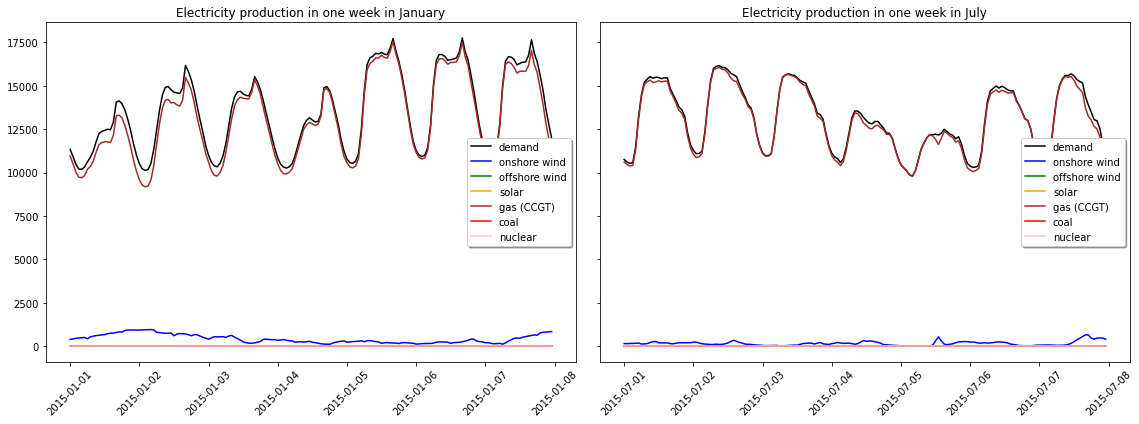

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # 1 row, 2 columns

# --- Winter Week (January) ---
axes[0].plot(network.loads_t.p['load'][0:168], color='black', label='demand')
axes[0].plot(network.generators_t.p['onshorewind'][0:168], color='blue', label='onshore wind')
axes[0].plot(network.generators_t.p['offshorewind'][0:168], color='green', label='offshore wind')
axes[0].plot(network.generators_t.p['solar'][0:168], color='orange', label='solar')
axes[0].plot(network.generators_t.p['CCGT'][0:168], color='brown', label='gas (CCGT)')
axes[0].plot(network.generators_t.p['coal'][0:168], color='red', label='coal')
axes[0].plot(network.generators_t.p['nuclear'][0:168], color='pink', label='nuclear')
axes[0].legend(fancybox=True, shadow=True, loc='best')
axes[0].set_title('Electricity production in one week in January')
axes[0].tick_params(axis='x', rotation=45)

# --- Summer Week (July) ---
axes[1].plot(network.loads_t.p['load'][4344:4512], color='black', label='demand')
axes[1].plot(network.generators_t.p['onshorewind'][4344:4512], color='blue', label='onshore wind')
axes[1].plot(network.generators_t.p['offshorewind'][4344:4512], color='green', label='offshore wind')
axes[1].plot(network.generators_t.p['solar'][4344:4512], color='orange', label='solar')
axes[1].plot(network.generators_t.p['CCGT'][4344:4512], color='brown', label='gas (CCGT)')
axes[1].plot(network.generators_t.p['coal'][4344:4512], color='red', label='coal')
axes[1].plot(network.generators_t.p['nuclear'][4344:4512], color='pink', label='nuclear')
axes[1].legend(fancybox=True, shadow=True, loc='best')
axes[1].set_title('Electricity production in one week in July')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Electricity mix

Text(0.5, 1.07, 'Electricity mix')

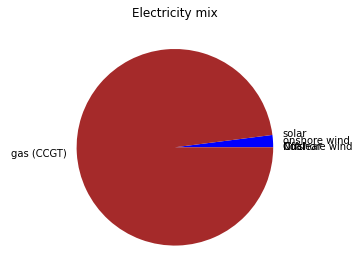

In [14]:
labels = ['onshore wind',
          'solar',
          'gas (CCGT)',
          'Offshore wind',
          'Coal',
          'Nuclear']
sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['solar'].sum(),
         network.generators_t.p['CCGT'].sum(),
         network.generators_t.p['offshorewind'].sum(),
        network.generators_t.p['coal'].sum(),
        network.generators_t.p['nuclear'].sum()]

colors=['blue', 'orange', 'brown', 'green', 'red', 'pink']

plt.pie(sizes,
        colors=colors,
        labels=labels,
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

In [15]:
# Group dispatch by carrier manually
dispatch = network.generators_t.p
carrier_map = network.generators.carrier

# Match generator names to carriers
dispatch.columns = carrier_map[dispatch.columns].values

C:\Users\anjal\AppData\Local\Temp\ipykernel_8024\1457957073.py:2: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



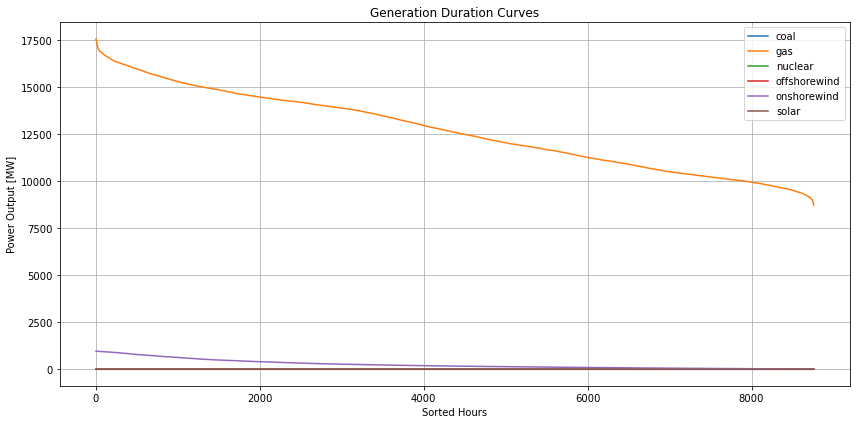

In [16]:
# Sum all generators by carrier
carrier_dispatch = dispatch.groupby(axis=1, level=0).sum()
# Duration curves
carrier_dispatch.apply(lambda x: x.sort_values(ascending=False).reset_index(drop=True)).plot(
    figsize=(12, 6), title="Generation Duration Curves")
plt.ylabel("Power Output [MW]")
plt.xlabel("Sorted Hours")
plt.grid(True)
plt.tight_layout()
plt.show()

## CO2 limit 

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  7.46it/s]
INFO:linopy.io: Writing time: 1.82s


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-05-03


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2026-05-03


Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-nejzpocb.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-nejzpocb.lp


Reading time = 0.53 seconds


INFO:gurobipy.gurobipy:Reading time = 0.53 seconds


obj: 113887 rows, 52566 columns, 223375 nonzeros


INFO:gurobipy.gurobipy:obj: 113887 rows, 52566 columns, 223375 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 6.92e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Generator
onshorewind     20301.695437
offshorewind        0.000000
solar           14475.825252
CCGT            17372.284741
coal                0.000000
nuclear             0.000000
Name: p_nom_opt, dtype: float64

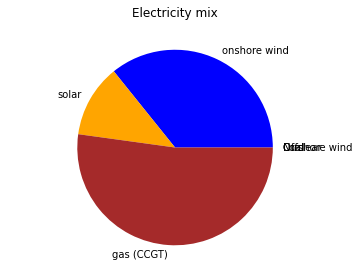

In [17]:
co2_limit=13000000#tonCO2
network.add("GlobalConstraint",
            "co2_limit_13MT",
            type="primary_energy",
            carrier_attribute="co2_emissions",
            sense="<=",
            constant=co2_limit)

#network.optimize(solver_name='gurobi')
network.optimize(solver_name='gurobi', solver_options={'OutputFlag': 0})



labels = ['onshore wind',
          'solar',
          'gas (CCGT)',
          'Offshore wind',
          'Coal',
          'Nuclear']
sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['solar'].sum(),
         network.generators_t.p['CCGT'].sum(),
         network.generators_t.p['offshorewind'].sum(),
        network.generators_t.p['coal'].sum(),
        network.generators_t.p['nuclear'].sum()]

colors=['blue', 'orange', 'brown', 'green', 'red', 'pink']    

plt.pie(sizes,
        colors=colors,
        labels=labels,
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

network.generators.p_nom_opt # in MW



INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  8.22it/s]
INFO:linopy.io: Writing time: 1.76s


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-05-03


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2026-05-03


Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-3_7qbycm.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-3_7qbycm.lp


Reading time = 0.51 seconds


INFO:gurobipy.gurobipy:Reading time = 0.51 seconds


obj: 113887 rows, 52566 columns, 223375 nonzeros


INFO:gurobipy.gurobipy:obj: 113887 rows, 52566 columns, 223375 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 1.36e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  8.21it/s]
INFO:linopy.io: Writing time: 1.68s


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-05-03


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2026-05-03


Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-u1p84f_9.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-u1p84f_9.lp


Reading time = 0.43 seconds


INFO:gurobipy.gurobipy:Reading time = 0.43 seconds


obj: 113887 rows, 52566 columns, 223375 nonzeros


INFO:gurobipy.gurobipy:obj: 113887 rows, 52566 columns, 223375 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 1.36e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  8.12it/s]
INFO:linopy.io: Writing time: 1.75s


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-05-03


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2026-05-03


Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-yn3tf0b5.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-yn3tf0b5.lp


Reading time = 0.45 seconds


INFO:gurobipy.gurobipy:Reading time = 0.45 seconds


obj: 113887 rows, 52566 columns, 223375 nonzeros


INFO:gurobipy.gurobipy:obj: 113887 rows, 52566 columns, 223375 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 1.36e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  7.84it/s]
INFO:linopy.io: Writing time: 1.83s


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-05-03


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2026-05-03


Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-4fvhe7in.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-4fvhe7in.lp


Reading time = 0.52 seconds


INFO:gurobipy.gurobipy:Reading time = 0.52 seconds


obj: 113887 rows, 52566 columns, 223375 nonzeros


INFO:gurobipy.gurobipy:obj: 113887 rows, 52566 columns, 223375 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 1.36e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  8.40it/s]
INFO:linopy.io: Writing time: 1.65s


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-05-03


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2026-05-03


Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-a7fhox_a.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-a7fhox_a.lp


Reading time = 0.42 seconds


INFO:gurobipy.gurobipy:Reading time = 0.42 seconds


obj: 113887 rows, 52566 columns, 223375 nonzeros


INFO:gurobipy.gurobipy:obj: 113887 rows, 52566 columns, 223375 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 1.36e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  8.38it/s]
INFO:linopy.io: Writing time: 1.65s


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-05-03


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2026-05-03


Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-y9jm1t30.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-y9jm1t30.lp


Reading time = 0.41 seconds


INFO:gurobipy.gurobipy:Reading time = 0.41 seconds


obj: 113887 rows, 52566 columns, 223375 nonzeros


INFO:gurobipy.gurobipy:obj: 113887 rows, 52566 columns, 223375 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 1.36e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  8.04it/s]
INFO:linopy.io: Writing time: 1.71s


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-05-03


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2026-05-03


Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-lu9evecm.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-lu9evecm.lp


Reading time = 0.47 seconds


INFO:gurobipy.gurobipy:Reading time = 0.47 seconds


obj: 113887 rows, 52566 columns, 223375 nonzeros


INFO:gurobipy.gurobipy:obj: 113887 rows, 52566 columns, 223375 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 1.36e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  8.27it/s]
INFO:linopy.io: Writing time: 1.74s


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-05-03


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2026-05-03


Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-igh0fi_d.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-igh0fi_d.lp


Reading time = 0.42 seconds


INFO:gurobipy.gurobipy:Reading time = 0.42 seconds


obj: 113887 rows, 52566 columns, 223375 nonzeros


INFO:gurobipy.gurobipy:obj: 113887 rows, 52566 columns, 223375 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 1.36e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  8.47it/s]
INFO:linopy.io: Writing time: 1.66s


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-05-03


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2026-05-03


Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-z5h702tl.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-z5h702tl.lp


Reading time = 0.42 seconds


INFO:gurobipy.gurobipy:Reading time = 0.42 seconds


obj: 113887 rows, 52566 columns, 223375 nonzeros


INFO:gurobipy.gurobipy:obj: 113887 rows, 52566 columns, 223375 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 1.36e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  8.07it/s]
INFO:linopy.io: Writing time: 1.89s


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-05-03


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2026-05-03


Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-p3crwwic.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-p3crwwic.lp


Reading time = 0.44 seconds


INFO:gurobipy.gurobipy:Reading time = 0.44 seconds


obj: 113887 rows, 52566 columns, 223375 nonzeros


INFO:gurobipy.gurobipy:obj: 113887 rows, 52566 columns, 223375 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 1.36e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


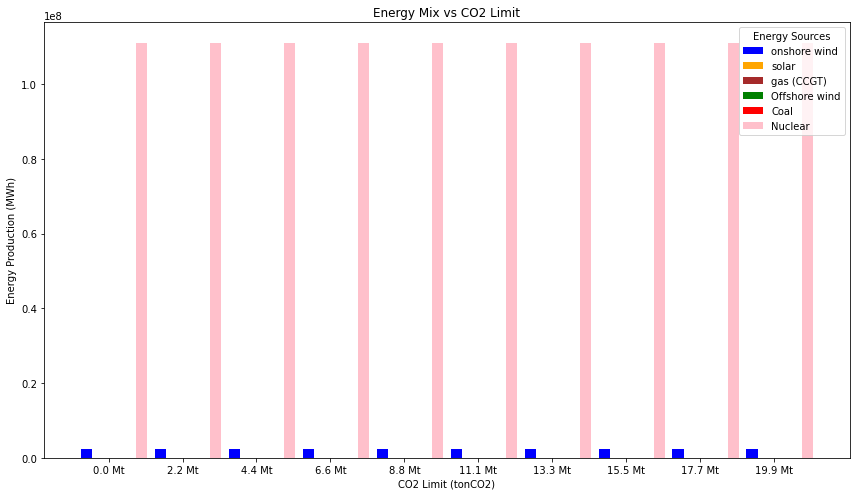

In [18]:
co2_limits = np.linspace(0, 19.9e6, 10)  
network.remove("GlobalConstraint", "co2_limit_13MT")

energy_mixes = []
for co2_limit in co2_limits:
    
    
    network.add("GlobalConstraint",
                "co2_limit",  
                type="primary_energy",
                carrier_attribute="co2_emissions",
                sense="<=",
                constant=co2_limit)
    network.optimize(solver_name='gurobi', solver_options={'OutputFlag': 0})
    sizes = [network.generators_t.p['onshorewind'].sum(),
             network.generators_t.p['solar'].sum(),
             network.generators_t.p['CCGT'].sum(),
             network.generators_t.p['offshorewind'].sum(),
             network.generators_t.p['coal'].sum(),
             network.generators_t.p['nuclear'].sum()]
    energy_mixes.append(sizes)

energy_mixes = np.array(energy_mixes)


# Plot
labels = ['onshore wind', 'solar', 'gas (CCGT)', 'Offshore wind', 'Coal', 'Nuclear']
colors = ['blue', 'orange', 'brown', 'green', 'red', 'pink']
fig, ax1 = plt.subplots(figsize=(12, 7))
x = np.arange(len(co2_limits)) 
bar_width = 0.15 
for i, label in enumerate(labels):
    ax1.bar(x + i * bar_width, energy_mixes[:, i], bar_width, label=label, color=colors[i])
ax1.set_xlabel('CO2 Limit (tonCO2)')
ax1.set_ylabel('Energy Production (MWh)')
ax1.set_title('Energy Mix vs CO2 Limit')
ax1.set_xticks(x + bar_width * 2) 
ax1.set_xticklabels([f'{co2_limit / 1e6:.1f} Mt' for co2_limit in co2_limits]) 
ax1.legend(title="Energy Sources")
fig.tight_layout()

plt.show()


In [19]:
print(network.objective/1000000) #in 10^6 €

13598.554986190707


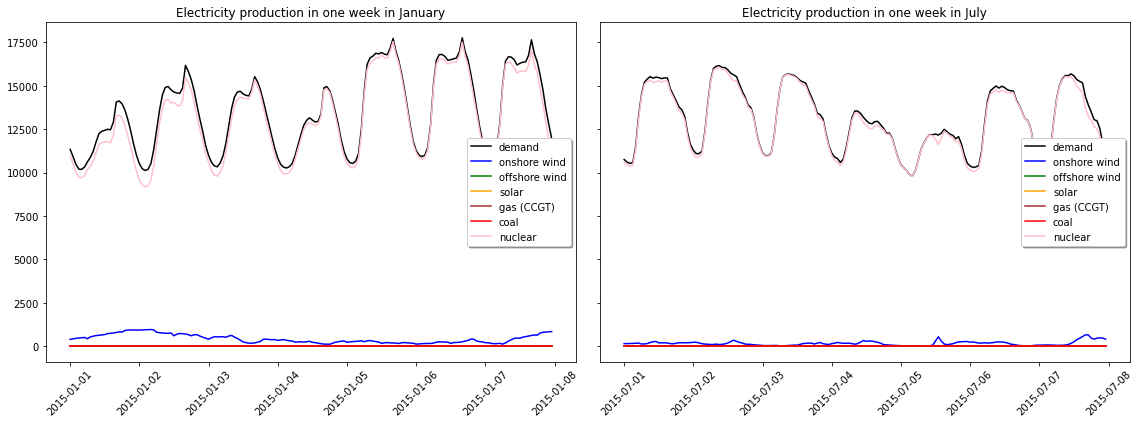

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # 1 row, 2 columns

# --- Winter Week (January) ---
axes[0].plot(network.loads_t.p['load'][0:168], color='black', label='demand')
axes[0].plot(network.generators_t.p['onshorewind'][0:168], color='blue', label='onshore wind')
axes[0].plot(network.generators_t.p['offshorewind'][0:168], color='green', label='offshore wind')
axes[0].plot(network.generators_t.p['solar'][0:168], color='orange', label='solar')
axes[0].plot(network.generators_t.p['CCGT'][0:168], color='brown', label='gas (CCGT)')
axes[0].plot(network.generators_t.p['coal'][0:168], color='red', label='coal')
axes[0].plot(network.generators_t.p['nuclear'][0:168], color='pink', label='nuclear')
axes[0].legend(fancybox=True, shadow=True, loc='best')
axes[0].set_title('Electricity production in one week in January')
axes[0].tick_params(axis='x', rotation=45)

# --- Summer Week (July) ---
axes[1].plot(network.loads_t.p['load'][4344:4512], color='black', label='demand')
axes[1].plot(network.generators_t.p['onshorewind'][4344:4512], color='blue', label='onshore wind')
axes[1].plot(network.generators_t.p['offshorewind'][4344:4512], color='green', label='offshore wind')
axes[1].plot(network.generators_t.p['solar'][4344:4512], color='orange', label='solar')
axes[1].plot(network.generators_t.p['CCGT'][4344:4512], color='brown', label='gas (CCGT)')
axes[1].plot(network.generators_t.p['coal'][4344:4512], color='red', label='coal')
axes[1].plot(network.generators_t.p['nuclear'][4344:4512], color='pink', label='nuclear')
axes[1].legend(fancybox=True, shadow=True, loc='best')
axes[1].set_title('Electricity production in one week in July')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Part D. Adding Storage Technology

In [21]:
network.add("Carrier", "battery", overwrite = True)
network.add("Carrier", "pumped hydro", overwrite = True)

# add storage units (battery and pumped hydro)
network.add("StorageUnit", "battery", 
            bus="electricity bus",
            p_nom_max = 300,
            max_hours=2,
            p_nom_extendable = True,
            efficiency_store=0.9,
            efficiency_dispatch=0.9,
            capital_cost=0, # in €/MW
            marginal_cost=0,
            carrier="battery",
            overwrite = True,
            cyclic_state_of_charge=True)

network.add("StorageUnit", "pumped_hydro",
            bus="electricity bus",
            p_nom_max = 500,
            max_hours=6,
            p_nom_extendable = True,
            efficiency_store=0.9,
            efficiency_dispatch=0.9,
            capital_cost= 0, # in €/MW
            marginal_cost=0,
            carrier="pumped hydro",
            overwrite = True,
            cyclic_state_of_charge=True)

Index(['pumped_hydro'], dtype='object')

In [22]:
network.storage_units.head(3)

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,state_of_charge_initial_per_period,state_of_charge_set,cyclic_state_of_charge,cyclic_state_of_charge_per_period,max_hours,efficiency_store,efficiency_dispatch,standing_loss,inflow,p_nom_opt
StorageUnit,,,,,,,,,,,,,,,,,,,,,
battery,electricity bus,PQ,,0.0,0.0,True,0.0,300.0,-1.0,1.0,...,False,NaN,True,True,2.0,0.9,0.9,0.0,0.0,0.0
pumped_hydro,electricity bus,PQ,,0.0,0.0,True,0.0,500.0,-1.0,1.0,...,False,NaN,True,True,6.0,0.9,0.9,0.0,0.0,0.0


In [23]:
network.optimize(solver_name='gurobi')

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 12.03it/s]
INFO:linopy.io: Writing time: 3.45s


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-05-03


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2026-05-03


Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-eh6d9xw8.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-eh6d9xw8.lp


Reading time = 0.85 seconds


INFO:gurobipy.gurobipy:Reading time = 0.85 seconds


obj: 236531 rows, 105128 columns, 486179 nonzeros


INFO:gurobipy.gurobipy:obj: 236531 rows, 105128 columns, 486179 nonzeros


Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)


INFO:gurobipy.gurobipy:Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)


INFO:gurobipy.gurobipy:


CPU model: AMD Ryzen 5 5600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy.gurobipy:CPU model: AMD Ryzen 5 5600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy.gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy.gurobipy:


Optimize a model with 236531 rows, 105128 columns and 486179 nonzeros


INFO:gurobipy.gurobipy:Optimize a model with 236531 rows, 105128 columns and 486179 nonzeros


Model fingerprint: 0xb91a24eb


INFO:gurobipy.gurobipy:Model fingerprint: 0xb91a24eb


Coefficient statistics:


INFO:gurobipy.gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 6e+00]


INFO:gurobipy.gurobipy:  Matrix range     [1e-03, 6e+00]


  Objective range  [2e+01, 6e+05]


INFO:gurobipy.gurobipy:  Objective range  [2e+01, 6e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy.gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [3e+02, 2e+04]


INFO:gurobipy.gurobipy:  RHS range        [3e+02, 2e+04]


Presolve removed 179602 rows and 21915 columns


INFO:gurobipy.gurobipy:Presolve removed 179602 rows and 21915 columns


Presolve time: 0.28s


INFO:gurobipy.gurobipy:Presolve time: 0.28s


Presolved: 56929 rows, 83213 columns, 197067 nonzeros


INFO:gurobipy.gurobipy:Presolved: 56929 rows, 83213 columns, 197067 nonzeros


INFO:gurobipy.gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy.gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy.gurobipy:Showing barrier log only...


INFO:gurobipy.gurobipy:


Ordering time: 0.03s


INFO:gurobipy.gurobipy:Ordering time: 0.03s


INFO:gurobipy.gurobipy:


Barrier statistics:


INFO:gurobipy.gurobipy:Barrier statistics:


 Dense cols : 4


INFO:gurobipy.gurobipy: Dense cols : 4


 AA' NZ     : 9.634e+04


INFO:gurobipy.gurobipy: AA' NZ     : 9.634e+04


 Factor NZ  : 7.446e+05 (roughly 60 MB of memory)


INFO:gurobipy.gurobipy: Factor NZ  : 7.446e+05 (roughly 60 MB of memory)


 Factor Ops : 1.025e+07 (less than 1 second per iteration)


INFO:gurobipy.gurobipy: Factor Ops : 1.025e+07 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy.gurobipy: Threads    : 4


INFO:gurobipy.gurobipy:


                  Objective                Residual


INFO:gurobipy.gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy.gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.36804492e+10 -1.00995535e+11  9.90e+04 0.00e+00  4.84e+07     1s


INFO:gurobipy.gurobipy:   0   6.36804492e+10 -1.00995535e+11  9.90e+04 0.00e+00  4.84e+07     1s


   1   1.02530558e+11 -1.90139199e+11  9.18e+03 2.94e+02  6.96e+06     1s


INFO:gurobipy.gurobipy:   1   1.02530558e+11 -1.90139199e+11  9.18e+03 2.94e+02  6.96e+06     1s


   2   6.82642360e+10 -7.44955526e+10  2.91e-11 1.15e+01  7.79e+05     1s


INFO:gurobipy.gurobipy:   2   6.82642360e+10 -7.44955526e+10  2.91e-11 1.15e+01  7.79e+05     1s


   3   3.29775648e+10 -1.51392777e+10  8.73e-11 1.97e+00  2.52e+05     1s


INFO:gurobipy.gurobipy:   3   3.29775648e+10 -1.51392777e+10  8.73e-11 1.97e+00  2.52e+05     1s


   4   3.07948774e+10 -1.08619238e+10  6.26e-10 1.64e+00  2.17e+05     1s


INFO:gurobipy.gurobipy:   4   3.07948774e+10 -1.08619238e+10  6.26e-10 1.64e+00  2.17e+05     1s


   5   2.99091727e+10 -6.60921033e+09  4.05e-09 1.36e+00  1.90e+05     1s


INFO:gurobipy.gurobipy:   5   2.99091727e+10 -6.60921033e+09  4.05e-09 1.36e+00  1.90e+05     1s


   6   2.65660360e+10 -4.91427308e+09  4.30e-08 1.24e+00  1.64e+05     2s


INFO:gurobipy.gurobipy:   6   2.65660360e+10 -4.91427308e+09  4.30e-08 1.24e+00  1.64e+05     2s


   7   2.10496729e+10  2.32769869e+09  3.04e-07 8.13e-01  9.70e+04     2s


INFO:gurobipy.gurobipy:   7   2.10496729e+10  2.32769869e+09  3.04e-07 8.13e-01  9.70e+04     2s


   8   1.78393604e+10  7.91253253e+09  1.87e-07 3.08e-01  5.12e+04     2s


INFO:gurobipy.gurobipy:   8   1.78393604e+10  7.91253253e+09  1.87e-07 3.08e-01  5.12e+04     2s


   9   1.56977868e+10  1.05266673e+10  3.30e-07 1.52e-01  2.66e+04     2s


INFO:gurobipy.gurobipy:   9   1.56977868e+10  1.05266673e+10  3.30e-07 1.52e-01  2.66e+04     2s


  10   1.45170798e+10  1.13796598e+10  7.76e-08 1.19e-01  1.61e+04     2s


INFO:gurobipy.gurobipy:  10   1.45170798e+10  1.13796598e+10  7.76e-08 1.19e-01  1.61e+04     2s


  11   1.37884111e+10  1.21195932e+10  4.25e-07 6.05e-02  8.59e+03     2s


INFO:gurobipy.gurobipy:  11   1.37884111e+10  1.21195932e+10  4.25e-07 6.05e-02  8.59e+03     2s


  12   1.32762401e+10  1.27230533e+10  5.25e-07 1.42e-02  2.84e+03     3s


INFO:gurobipy.gurobipy:  12   1.32762401e+10  1.27230533e+10  5.25e-07 1.42e-02  2.84e+03     3s


  13   1.31480099e+10  1.29441903e+10  6.29e-07 3.35e-03  1.04e+03     3s


INFO:gurobipy.gurobipy:  13   1.31480099e+10  1.29441903e+10  6.29e-07 3.35e-03  1.04e+03     3s


  14   1.31269584e+10  1.30218536e+10  5.60e-07 7.05e-05  5.35e+02     3s


INFO:gurobipy.gurobipy:  14   1.31269584e+10  1.30218536e+10  5.60e-07 7.05e-05  5.35e+02     3s


  15   1.31351712e+10  1.30575652e+10  1.55e-04 3.24e-05  3.94e+02     3s


INFO:gurobipy.gurobipy:  15   1.31351712e+10  1.30575652e+10  1.55e-04 3.24e-05  3.94e+02     3s


  16   1.31177398e+10  1.30711645e+10  1.54e-04 1.91e-09  2.37e+02     3s


INFO:gurobipy.gurobipy:  16   1.31177398e+10  1.30711645e+10  1.54e-04 1.91e-09  2.37e+02     3s


  17   1.31028432e+10  1.30766416e+10  9.78e-05 2.58e-09  1.33e+02     3s


INFO:gurobipy.gurobipy:  17   1.31028432e+10  1.30766416e+10  9.78e-05 2.58e-09  1.33e+02     3s


  18   1.30949609e+10  1.30781450e+10  7.38e-05 2.91e-09  8.54e+01     4s


INFO:gurobipy.gurobipy:  18   1.30949609e+10  1.30781450e+10  7.38e-05 2.91e-09  8.54e+01     4s


  19   1.30887784e+10  1.30791077e+10  5.75e-05 1.07e-09  4.91e+01     4s


INFO:gurobipy.gurobipy:  19   1.30887784e+10  1.30791077e+10  5.75e-05 1.07e-09  4.91e+01     4s


  20   1.30844895e+10  1.30792539e+10  4.04e-05 1.24e-09  2.66e+01     4s


INFO:gurobipy.gurobipy:  20   1.30844895e+10  1.30792539e+10  4.04e-05 1.24e-09  2.66e+01     4s


  21   1.30816108e+10  1.30793984e+10  3.60e-05 5.28e-10  1.12e+01     4s


INFO:gurobipy.gurobipy:  21   1.30816108e+10  1.30793984e+10  3.60e-05 5.28e-10  1.12e+01     4s


  22   1.30798941e+10  1.30796484e+10  4.92e-05 5.73e-10  1.25e+00     4s


INFO:gurobipy.gurobipy:  22   1.30798941e+10  1.30796484e+10  4.92e-05 5.73e-10  1.25e+00     4s


  23   1.30798620e+10  1.30796601e+10  4.16e-05 6.23e-10  1.02e+00     5s


INFO:gurobipy.gurobipy:  23   1.30798620e+10  1.30796601e+10  4.16e-05 6.23e-10  1.02e+00     5s


  24   1.30797538e+10  1.30796714e+10  1.67e-05 1.33e-09  4.18e-01     5s


INFO:gurobipy.gurobipy:  24   1.30797538e+10  1.30796714e+10  1.67e-05 1.33e-09  4.18e-01     5s


INFO:gurobipy.gurobipy:


Barrier performed 24 iterations in 4.96 seconds (0.84 work units)


INFO:gurobipy.gurobipy:Barrier performed 24 iterations in 4.96 seconds (0.84 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy.gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy.gurobipy:


INFO:gurobipy.gurobipy:


Solved with dual simplex


INFO:gurobipy.gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy.gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   31732    1.3079683e+10   0.000000e+00   0.000000e+00      5s


INFO:gurobipy.gurobipy:   31732    1.3079683e+10   0.000000e+00   0.000000e+00      5s


INFO:gurobipy.gurobipy:


Solved in 31732 iterations and 5.13 seconds (2.57 work units)


INFO:gurobipy.gurobipy:Solved in 31732 iterations and 5.13 seconds (2.57 work units)


Optimal objective  1.307968251e+10


INFO:gurobipy.gurobipy:Optimal objective  1.307968251e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 236531 duals
Objective: 1.31e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

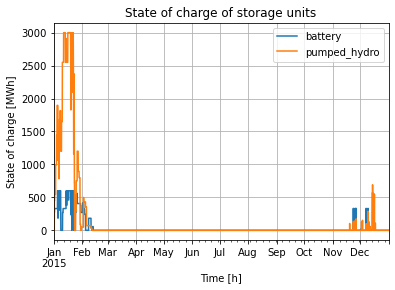

In [24]:
#plotting state of charge of storage units
network.storage_units_t.state_of_charge.plot()
plt.title('State of charge of storage units')
plt.xlabel('Time [h]')
plt.ylabel('State of charge [MWh]')
plt.legend(network.storage_units.index, loc='best')
plt.grid(True)
plt.show()

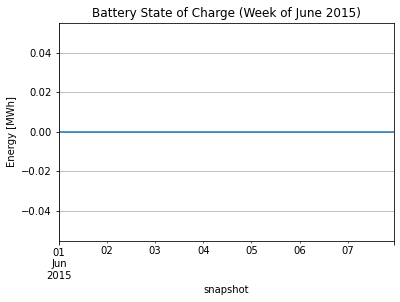

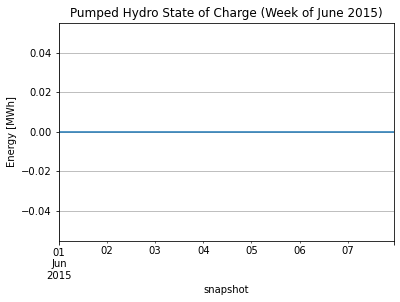

In [25]:
network.storage_units_t.state_of_charge["battery"].loc["2015-06-01":"2015-06-07"].plot()
plt.title("Battery State of Charge (Week of June 2015)")
plt.ylabel("Energy [MWh]")
plt.grid()
plt.show()

network.storage_units_t.state_of_charge["pumped_hydro"].loc["2015-06-01":"2015-06-07"].plot()
plt.title("Pumped Hydro State of Charge (Week of June 2015)")
plt.ylabel("Energy [MWh]")
plt.grid()
plt.show()

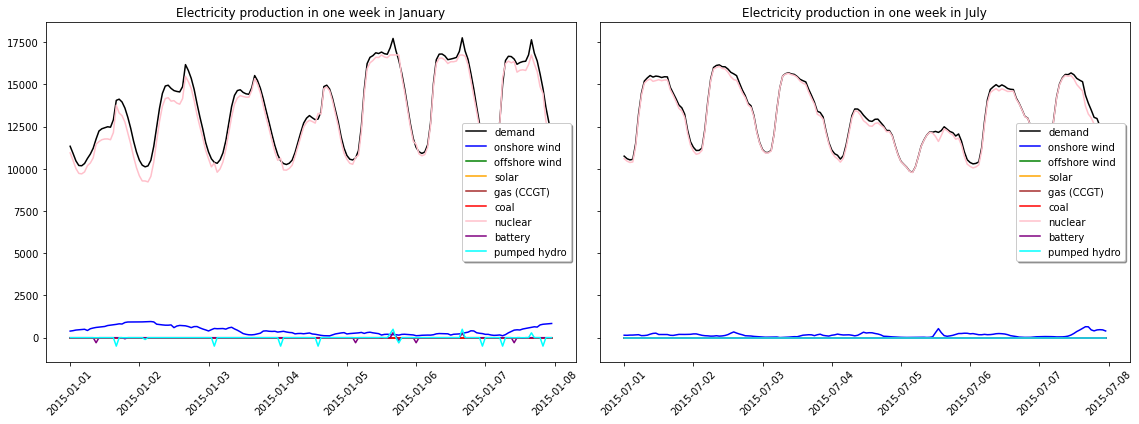

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # 1 row, 2 columns

# --- Winter Week (January) ---
axes[0].plot(network.loads_t.p['load'][0:168], color='black', label='demand')
axes[0].plot(network.generators_t.p['onshorewind'][0:168], color='blue', label='onshore wind')
axes[0].plot(network.generators_t.p['offshorewind'][0:168], color='green', label='offshore wind')
axes[0].plot(network.generators_t.p['solar'][0:168], color='orange', label='solar')
axes[0].plot(network.generators_t.p['CCGT'][0:168], color='brown', label='gas (CCGT)')
axes[0].plot(network.generators_t.p['coal'][0:168], color='red', label='coal')
axes[0].plot(network.generators_t.p['nuclear'][0:168], color='pink', label='nuclear')
axes[0].plot(network.storage_units_t.p['battery'][0:168], color='purple', label='battery')
axes[0].plot(network.storage_units_t.p['pumped_hydro'][0:168], color='cyan', label='pumped hydro')
axes[0].legend(fancybox=True, shadow=True, loc='best')
axes[0].set_title('Electricity production in one week in January')
axes[0].tick_params(axis='x', rotation=45)

# --- Summer Week (July) ---
axes[1].plot(network.loads_t.p['load'][4344:4512], color='black', label='demand')
axes[1].plot(network.generators_t.p['onshorewind'][4344:4512], color='blue', label='onshore wind')
axes[1].plot(network.generators_t.p['offshorewind'][4344:4512], color='green', label='offshore wind')
axes[1].plot(network.generators_t.p['solar'][4344:4512], color='orange', label='solar')
axes[1].plot(network.generators_t.p['CCGT'][4344:4512], color='brown', label='gas (CCGT)')
axes[1].plot(network.generators_t.p['coal'][4344:4512], color='red', label='coal')
axes[1].plot(network.generators_t.p['nuclear'][4344:4512], color='pink', label='nuclear')
axes[1].plot(network.storage_units_t.p['battery'][4344:4512], color='purple', label='battery')
axes[1].plot(network.storage_units_t.p['pumped_hydro'][4344:4512], color='cyan', label='pumped hydro')
axes[1].legend(fancybox=True, shadow=True, loc='best')
axes[1].set_title('Electricity production in one week in July')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Part E: target for decarbonization

In [27]:
co2_limit = 13e6  

co2_prices = []


network.remove("GlobalConstraint", "co2_limit")


network.add("GlobalConstraint",
            "co2_limit",
            type="primary_energy",
            carrier_attribute="co2_emissions",
            sense="<=",
            constant=co2_limit)

network.optimize(solver_name='gurobi', solver_options={'OutputFlag': 0})

co2_price = network.global_constraints.mu
co2_prices.append(co2_price)


print(f"CO2 Limit: {co2_limit / 1e6:.1f} Mt, CO2 Price: {co2_price}")


INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 11.05it/s]
INFO:linopy.io: Writing time: 3.56s


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-05-03


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2026-05-03


Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-2j7i2df4.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-2j7i2df4.lp


Reading time = 0.88 seconds


INFO:gurobipy.gurobipy:Reading time = 0.88 seconds


obj: 236531 rows, 105128 columns, 486179 nonzeros


INFO:gurobipy.gurobipy:obj: 236531 rows, 105128 columns, 486179 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 236531 duals
Objective: 6.82e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


CO2 Limit: 13.0 Mt, CO2 Price: GlobalConstraint
co2_limit   -97.876678
Name: mu, dtype: float64


INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 12.23it/s]
INFO:linopy.io: Writing time: 3.46s


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-05-03


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2026-05-03


Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-z5et7i1w.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-z5et7i1w.lp


Reading time = 0.82 seconds


INFO:gurobipy.gurobipy:Reading time = 0.82 seconds


obj: 236531 rows, 105128 columns, 486179 nonzeros


INFO:gurobipy.gurobipy:obj: 236531 rows, 105128 columns, 486179 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 236531 duals
Objective: 1.31e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 12.29it/s]
INFO:linopy.io: Writing time: 3.58s


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-05-03


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2026-05-03


Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-fd04znrn.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-fd04znrn.lp


Reading time = 0.87 seconds


INFO:gurobipy.gurobipy:Reading time = 0.87 seconds


obj: 236531 rows, 105128 columns, 486179 nonzeros


INFO:gurobipy.gurobipy:obj: 236531 rows, 105128 columns, 486179 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 236531 duals
Objective: 9.90e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 10.22it/s]
INFO:linopy.io: Writing time: 3.83s


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-05-03


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2026-05-03


Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-ttybbj1w.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-ttybbj1w.lp


Reading time = 0.98 seconds


INFO:gurobipy.gurobipy:Reading time = 0.98 seconds


obj: 236531 rows, 105128 columns, 486179 nonzeros


INFO:gurobipy.gurobipy:obj: 236531 rows, 105128 columns, 486179 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 236531 duals
Objective: 9.06e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 11.27it/s]
INFO:linopy.io: Writing time: 3.74s


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-05-03


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2026-05-03


Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-b94kj03i.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-b94kj03i.lp


Reading time = 0.87 seconds


INFO:gurobipy.gurobipy:Reading time = 0.87 seconds


obj: 236531 rows, 105128 columns, 486179 nonzeros


INFO:gurobipy.gurobipy:obj: 236531 rows, 105128 columns, 486179 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 236531 duals
Objective: 8.34e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 11.82it/s]
INFO:linopy.io: Writing time: 3.48s


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-05-03


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2026-05-03


Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-t_3jrk6r.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-t_3jrk6r.lp


Reading time = 0.83 seconds


INFO:gurobipy.gurobipy:Reading time = 0.83 seconds


obj: 236531 rows, 105128 columns, 486179 nonzeros


INFO:gurobipy.gurobipy:obj: 236531 rows, 105128 columns, 486179 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 236531 duals
Objective: 7.66e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 11.61it/s]
INFO:linopy.io: Writing time: 3.72s


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-05-03


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2026-05-03


Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-rwomwd5h.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-rwomwd5h.lp


Reading time = 0.92 seconds


INFO:gurobipy.gurobipy:Reading time = 0.92 seconds


obj: 236531 rows, 105128 columns, 486179 nonzeros


INFO:gurobipy.gurobipy:obj: 236531 rows, 105128 columns, 486179 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 236531 duals
Objective: 7.09e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 11.14it/s]
INFO:linopy.io: Writing time: 3.81s


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-05-03


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2026-05-03


Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-8r55ecnl.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-8r55ecnl.lp


Reading time = 0.84 seconds


INFO:gurobipy.gurobipy:Reading time = 0.84 seconds


obj: 236531 rows, 105128 columns, 486179 nonzeros


INFO:gurobipy.gurobipy:obj: 236531 rows, 105128 columns, 486179 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 236531 duals
Objective: 6.79e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 10.79it/s]
INFO:linopy.io: Writing time: 3.8s


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-05-03


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2026-05-03


Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-mmg099q4.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-mmg099q4.lp


Reading time = 0.95 seconds


INFO:gurobipy.gurobipy:Reading time = 0.95 seconds


obj: 236531 rows, 105128 columns, 486179 nonzeros


INFO:gurobipy.gurobipy:obj: 236531 rows, 105128 columns, 486179 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 236531 duals
Objective: 6.64e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 10.80it/s]
INFO:linopy.io: Writing time: 3.83s


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-05-03


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2026-05-03


Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-r7frz01m.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-r7frz01m.lp


Reading time = 0.92 seconds


INFO:gurobipy.gurobipy:Reading time = 0.92 seconds


obj: 236531 rows, 105128 columns, 486179 nonzeros


INFO:gurobipy.gurobipy:obj: 236531 rows, 105128 columns, 486179 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 236531 duals
Objective: 6.55e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 11.49it/s]
INFO:linopy.io: Writing time: 3.65s


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-05-03


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2026-05-03


Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-j02c9a4j.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-j02c9a4j.lp


Reading time = 0.95 seconds


INFO:gurobipy.gurobipy:Reading time = 0.95 seconds


obj: 236531 rows, 105128 columns, 486179 nonzeros


INFO:gurobipy.gurobipy:obj: 236531 rows, 105128 columns, 486179 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 236531 duals
Objective: 6.52e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


CO2 Prices for each CO2 limit:
CO2 Limit: 0.0 Mt, CO2 Price: GlobalConstraint
co2_limit   -2.414016e+06
Name: mu, dtype: float64 EUR/ton
CO2 Limit: 2.2 Mt, CO2 Price: GlobalConstraint
co2_limit   -435.114071
Name: mu, dtype: float64 EUR/ton
CO2 Limit: 4.4 Mt, CO2 Price: GlobalConstraint
co2_limit   -345.617891
Name: mu, dtype: float64 EUR/ton
CO2 Limit: 6.6 Mt, CO2 Price: GlobalConstraint
co2_limit   -313.881096
Name: mu, dtype: float64 EUR/ton
CO2 Limit: 8.8 Mt, CO2 Price: GlobalConstraint
co2_limit   -295.257384
Name: mu, dtype: float64 EUR/ton
CO2 Limit: 11.1 Mt, CO2 Price: GlobalConstraint
co2_limit   -195.790772
Name: mu, dtype: float64 EUR/ton
CO2 Limit: 13.3 Mt, CO2 Price: GlobalConstraint
co2_limit   -89.544153
Name: mu, dtype: float64 EUR/ton
CO2 Limit: 15.5 Mt, CO2 Price: GlobalConstraint
co2_limit   -53.49823
Name: mu, dtype: float64 EUR/ton
CO2 Limit: 17.7 Mt, CO2 Price: GlobalConstraint
co2_limit   -25.907186
Name: mu, dtype: float64 EUR/ton
CO2 Limit: 19.9 Mt, CO2 Price: 

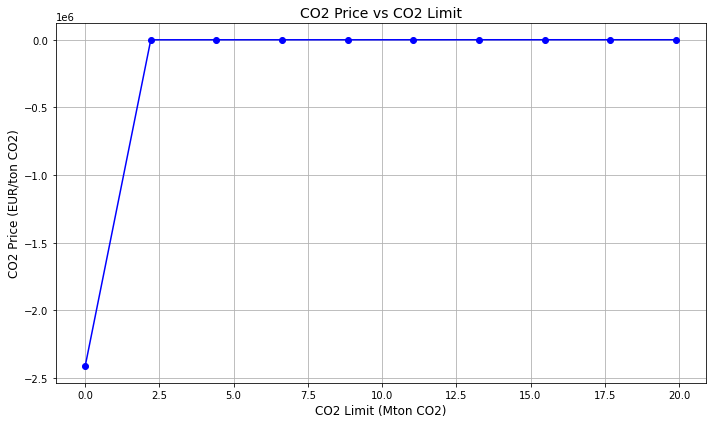

In [28]:
co2_limits = np.linspace(0, 19.9e6, 10)

co2_prices = []

for co2_limit in co2_limits:
    network.remove("GlobalConstraint", "co2_limit")
    
    network.add("GlobalConstraint",
                "co2_limit",
                type="primary_energy",
                carrier_attribute="co2_emissions",
                sense="<=",
                constant=co2_limit)
    
    network.optimize(solver_name='gurobi', solver_options={'OutputFlag': 0})
    
    co2_price = network.global_constraints.mu
    co2_prices.append(co2_price)

print("CO2 Prices for each CO2 limit:")
for co2_limit, co2_price in zip(co2_limits, co2_prices):
    print(f"CO2 Limit: {co2_limit / 1e6:.1f} Mt, CO2 Price: {co2_price} EUR/ton")


fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(co2_limits / 1e6, co2_prices, marker='o', linestyle='-', color='b')
ax1.set_xlabel('CO2 Limit (Mton CO2)', fontsize=12)
ax1.set_ylabel('CO2 Price (EUR/ton CO2)', fontsize=12)
ax1.set_title('CO2 Price vs CO2 Limit', fontsize=14)
ax1.grid(True)

plt.tight_layout()
plt.show()


Part F: Connect your country with, at least, two neighbouring countries.

In [32]:
file_path = "Data/electricity_demand.csv"
raw_data = pd.read_csv(file_path, sep=';', parse_dates=['utc_time'], index_col='utc_time')
raw_data.index = pd.to_datetime(raw_data.index, utc=True)

start_date = '2015-01-01 00:00:00+00:00'
end_date = '2015-12-31 23:00:00+00:00'
data_all = raw_data[start_date:end_date]



network.add("Bus", "electricity bus DNK", carrier="electricity")
network.add("Bus", "electricity bus GBR", carrier="electricity")


network.add("Load", "load DNK", bus="electricity bus DNK", p_set=data_all['DNK'].values)
network.add("Load", "load GBR", bus="electricity bus GBR", p_set=data_all['GBR'].values)

network.add("Link",
            "COBRAcable (NLD-DNK)",
            bus0="electricity bus",
            bus1="electricity bus DNK",
            p_nom=0,
            p_max = 700,
            p_nom_extendable=True,
            p_min_pu=-1,
            length=325,
            capital_cost=857142.86,
            overwrite = True)


network.add("Link",
            "BritNed (NLD-GBR)",
            bus0="electricity bus",
            bus1="electricity bus GBR",
            p_nom=0,
            p_max=1000,
            p_nom_extendable=True,  
            p_min_pu=-1,
            length=260,
            capital_cost=500000,
            overwrite=True)



Index(['BritNed (NLD-GBR)'], dtype='object')

In [33]:
# Generatorer
network.add("Generator", 
            "generator DK",
            bus="electricity bus DNK",
            p_nom_extendable=True,
            p_nom_max=1824, 
            overwrite=True)

network.add("Generator", 
            "generator GB",
            bus="electricity bus GBR",
            p_nom_extendable=True,
            p_nom_max=1010, 
            overwrite=True)

Index(['generator GB'], dtype='object')

In [34]:

network.optimize(solver_name='gurobi', solver_options={'OutputFlag': 0})

# Hent og print optimal kapasitet
print("Optimal capacity (MW):")
print(network.links.p_nom_opt)


network.generators.p_nom_opt

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 10.59it/s]
INFO:linopy.io: Writing time: 5.16s


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-05-03


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2026-05-03


Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-fwdmilzm.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-fwdmilzm.lp


Reading time = 1.21 seconds


INFO:gurobipy.gurobipy:Reading time = 1.21 seconds


obj: 324137 rows, 140172 columns, 661385 nonzeros


INFO:gurobipy.gurobipy:obj: 324137 rows, 140172 columns, 661385 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140172 primals, 324137 duals
Objective: 6.15e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Optimal capacity (MW):
Link
COBRAcable (NLD-DNK)     3885.95
BritNed (NLD-GBR)       51417.00
Name: p_nom_opt, dtype: float64


Generator
onshorewind     82592.726703
offshorewind        0.000000
solar           51428.592461
CCGT            53932.212551
coal                0.000000
nuclear         16437.632909
generator DK     1824.000000
generator GB     1010.000000
Name: p_nom_opt, dtype: float64

In [35]:
print(network.links.loc[:, ['carrier', 'p_nom', 'p_nom_extendable']])


                          carrier  p_nom  p_nom_extendable
Link                                                      
COBRAcable (NLD-DNK)  electricity    0.0              True
BritNed (NLD-GBR)     electricity    0.0              True


In [36]:
if "COBRAcable (NLD-DNK)" in network.links_t.p0.columns:
    cobracable_flow = network.links_t.p0["COBRAcable (NLD-DNK)"].sum()
else:
    cobracable_flow = 0.0

if "BritNed (NLD-GBR)" in network.links_t.p0.columns:
    britned_flow = network.links_t.p0["BritNed (NLD-GBR)"].sum()
else:
    britned_flow = 0.0


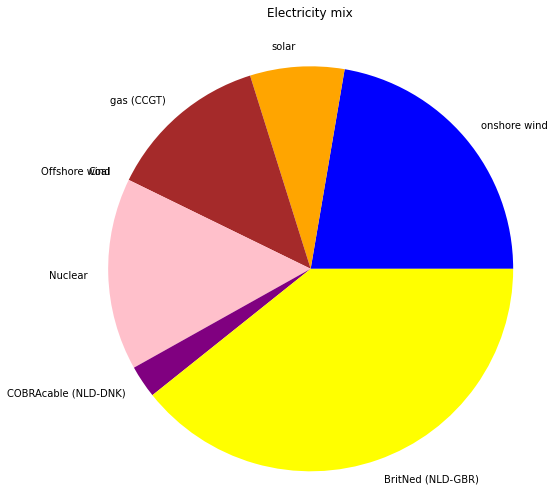

In [37]:
def safe_sum(series):
    return abs(series.sum()) if isinstance(series, pd.Series) else 0

labels = [
    'onshore wind',
    'solar',
    'gas (CCGT)',
    'Offshore wind',
    'Coal',
    'Nuclear', 
    'COBRAcable (NLD-DNK)',
    'BritNed (NLD-GBR)'
]

sizes = [
    safe_sum(network.generators_t.p.get('onshorewind')),
    safe_sum(network.generators_t.p.get('solar')),
    safe_sum(network.generators_t.p.get('CCGT')),
    safe_sum(network.generators_t.p.get('offshorewind')),
    safe_sum(network.generators_t.p.get('coal')),
    safe_sum(network.generators_t.p.get('nuclear')),
    safe_sum(network.links_t.p0.get('COBRAcable (NLD-DNK)', pd.Series(0))),
    safe_sum(network.links_t.p0.get('BritNed (NLD-GBR)', pd.Series(0)))
]

colors = [
    'blue', 'orange', 'brown', 'green',
    'red', 'pink', 'purple', 'yellow'
]

plt.figure(figsize=(8, 8))
plt.pie(sizes,
        colors=colors,
        labels=labels,
        wedgeprops={'linewidth': 0})
plt.axis('equal')
plt.title('Electricity mix', y=1.07)
plt.show()

In [38]:
cobra_flow = cobracable_flow
britned_flow = britned_flow

cobra_export_from_nld = max(cobra_flow, 0)
cobra_import_to_nld   = abs(min(cobra_flow, 0))

print("COBRAcable export from NLD:", cobra_export_from_nld)
print("COBRAcable import to NLD:", cobra_import_to_nld)

britned_export_from_nld = max(britned_flow, 0)
britned_import_to_nld   = abs(min(britned_flow, 0))

print("BritNed export from NLD:", britned_export_from_nld)
print("BritNed import to NLD:", britned_import_to_nld)


COBRAcable export from NLD: 18233155.94708877
COBRAcable import to NLD: 0
BritNed export from NLD: 274732566.48766404
BritNed import to NLD: 0


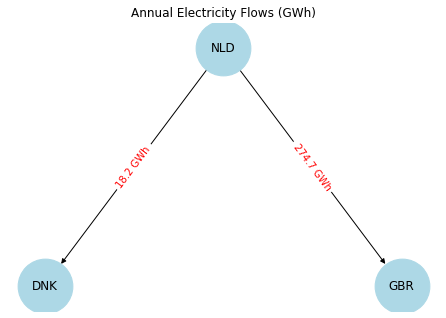

In [39]:
import networkx as nx
import matplotlib.pyplot as plt

# Create graph
G = nx.DiGraph()

# Add nodes
G.add_node("DNK")
G.add_node("GBR")
G.add_node("NLD")

# Add edges with weights (you can reverse direction depending on actual flows)
if cobra_flow > 0:
    G.add_edge("NLD", "DNK", weight=cobra_flow)
else:
    G.add_edge("DNK", "NLD", weight=abs(cobra_flow))

if britned_flow > 0:
    G.add_edge("NLD", "GBR", weight=britned_flow)
else:
    G.add_edge("GBR", "NLD", weight=abs(britned_flow))

# Draw
pos = {"DNK": (-1, 0), "NLD": (0, 1), "GBR": (1, 0)}
weights = [G[u][v]['weight'] / 1e6 for u, v in G.edges()]  # In MW or MWh

nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', arrows=True)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels={(u, v): f"{G[u][v]['weight'] / 1e6:.1f} GWh" for u, v in G.edges()},
    font_color='red'
)

plt.title("Annual Electricity Flows (GWh)")
plt.show()


Part G: Connect with heat sector

In [40]:
network.add("Carrier", "heat")


network.add("Bus",
            "heat bus",
            carrier="heat")

network.add("Bus", 
            "useful heat bus",
            carrier = "heat")

file_path_heat = "Data/heat_demand.csv"
heat_data = pd.read_csv(file_path_heat, sep=';', parse_dates=['utc_time'], index_col='utc_time')
heat_data.index = pd.to_datetime(heat_data.index, utc=True)


country = 'NLD'
heat_demand = heat_data[country]



heat_demand.index = heat_demand.index.tz_localize(None)
network.snapshots = network.snapshots.tz_localize(None)


heat_demand = heat_demand.reindex(network.snapshots, method='nearest')




In [41]:
network.add("Load",
            "heat load",
            bus="heat bus",
            p_set=heat_demand.values)

network.add("Store",
            "heat tank",
            bus="heat bus",
            e_nom_extendable=True,
            e_cyclic=True,
            capital_cost=annuity(25, 0.07)* 21420*(1+0.01))  

network.add("Link",
            "heat discharger",
            bus0="heat bus",
            bus1="useful heat bus",  # eller evt. en egen bus om nødvendig
            p_nom_extendable=True,
            efficiency=0.63,  # fra tabellen din
            capital_cost=annuity(33, 0.07) * 550809 * (1 + 0.03),  # justert kost
            carrier="heat")

network.add("Link",
            "heat pump",
            bus0="electricity bus",
            bus1="heat bus",
            p_nom_extendable=True,
            efficiency=0.99,
            capital_cost=annuity(5, 0.07)*784486*(1+0.03),  
            carrier="heat")


network.optimize(solver_name='gurobi', solver_options={'OutputFlag': 0})

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 11/11 [00:00<00:00, 11.13it/s]
INFO:linopy.io: Writing time: 6.03s


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-05-03


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2026-05-03


Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-b9nqkq8n.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-b9nqkq8n.lp


Reading time = 1.60 seconds


INFO:gurobipy.gurobipy:Reading time = 1.60 seconds


obj: 402980 rows, 175215 columns, 810308 nonzeros


INFO:gurobipy.gurobipy:obj: 402980 rows, 175215 columns, 810308 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 175215 primals, 402980 duals
Objective: 7.96e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

In [42]:
print("Optimal heat pump (MW):")
print(network.links.p_nom_opt[["heat pump"]])
print("Optimal heat tank (MWh):")
print(network.stores.e_nom_opt["heat tank"])

print(heat_demand.describe())
print(heat_demand.head())

Optimal heat pump (MW):
Link
heat pump    34814.423532
Name: p_nom_opt, dtype: float64
Optimal heat tank (MWh):
1319682.6186986398
count     8760.000000
mean     15844.849242
std      10169.239646
min       1837.890303
25%       7049.810280
50%      14746.807229
75%      24081.871112
max      41510.859460
Name: NLD, dtype: float64
snapshot
2015-01-01 00:00:00    30208.769643
2015-01-01 01:00:00    30178.483595
2015-01-01 02:00:00    30656.801254
2015-01-01 03:00:00    31221.195229
2015-01-01 04:00:00    31682.524876
Name: NLD, dtype: float64


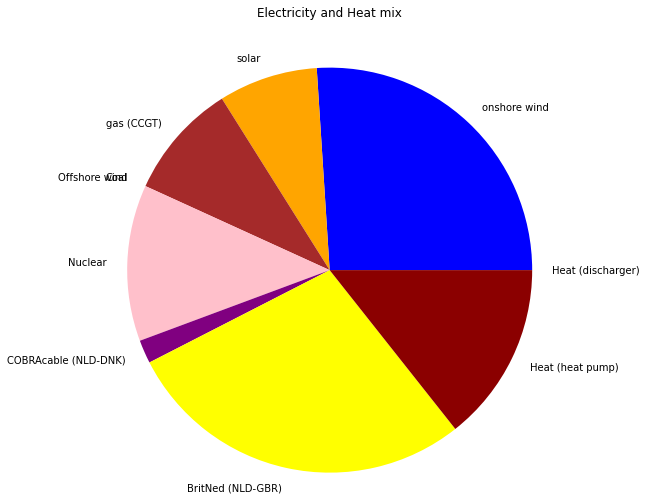

In [43]:
import matplotlib.pyplot as plt




labels = ['onshore wind',
          'solar',
          'gas (CCGT)',
          'Offshore wind',
          'Coal',
          'Nuclear', 
          'COBRAcable (NLD-DNK)',
          'BritNed (NLD-GBR)',
          'Heat (heat pump)',
          'Heat (discharger)']  # <-- Ny label

sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['solar'].sum(),
         network.generators_t.p['CCGT'].sum(),
         network.generators_t.p['offshorewind'].sum(),
         network.generators_t.p['coal'].sum(),
         network.generators_t.p['nuclear'].sum(),
         cobracable_flow,
         britned_flow,
    safe_sum(network.links_t.p0.get('heat pump', pd.Series(0))),
    safe_sum(network.links_t.p0.get('heat discharger', pd.Series(0)))]  

sizes = [abs(s) for s in sizes]

colors = ['blue', 'orange', 'brown', 'green', 'red', 'pink', 'purple', 'yellow', 'darkred', 'firebrick']  # <-- Ny farge

plt.figure(figsize=(8, 8))
plt.pie(sizes,
        colors=colors,
        labels=labels,
        wedgeprops={'linewidth': 0})
plt.axis('equal')
plt.title('Electricity and Heat mix', y=1.07)
plt.show()



In [44]:
network.generators.p_nom_opt # in MW

Generator
onshorewind     129094.078865
offshorewind         0.000000
solar            84136.518303
CCGT             52961.029387
coal                 0.000000
nuclear          20456.468163
generator DK      1824.000000
generator GB      1010.000000
Name: p_nom_opt, dtype: float64

Part H. Analayzing the Effect of the Lion Battery Storage Project in the Netherlands

In [45]:

network.add("Carrier", "lion_battery", overwrite = True)
network.add("StorageUnit", "lion_battery", 
            bus="electricity bus",
            p_nom_max = 350,
            max_hours=4,
            p_nom_extendable = True,
            efficiency_store=0.9,
            efficiency_dispatch=0.9,
            capital_cost=annuity(15,0.007)*300000,  # €/MW
            marginal_cost=0,
            carrier="battery",
            overwrite = True,
            cyclic_state_of_charge=True)

network.optimize(solver_name='gurobi', solver_options={'OutputFlag': 0})

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 11/11 [00:01<00:00,  9.97it/s]
INFO:linopy.io: Writing time: 7.35s


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-05-03


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2026-05-03


Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-cpfmklwq.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\anjal\AppData\Local\Temp\linopy-problem-cpfmklwq.lp


Reading time = 1.71 seconds


INFO:gurobipy.gurobipy:Reading time = 1.71 seconds


obj: 464302 rows, 201496 columns, 941710 nonzeros


INFO:gurobipy.gurobipy:obj: 464302 rows, 201496 columns, 941710 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 201496 primals, 464302 duals
Objective: 7.95e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

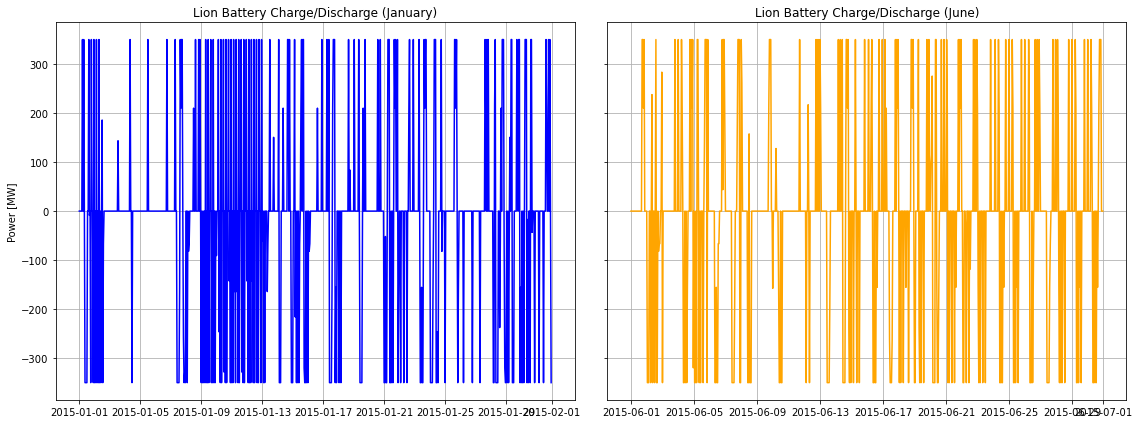

In [46]:
#Analyzing the Charging/Discharging Behavior of the Lion Battery for one Month in January and June
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # 1 row, 2 columns

# January
axes[0].plot(network.storage_units_t.p["lion_battery"].loc["2015-01-01":"2015-01-31"], color='blue')
axes[0].set_title("Lion Battery Charge/Discharge (January)")
axes[0].set_ylabel("Power [MW]")
axes[0].grid()

# June
axes[1].plot(network.storage_units_t.p["lion_battery"].loc["2015-06-01":"2015-06-30"], color='orange')
axes[1].set_title("Lion Battery Charge/Discharge (June)")
axes[1].grid()

plt.tight_layout()
plt.show()



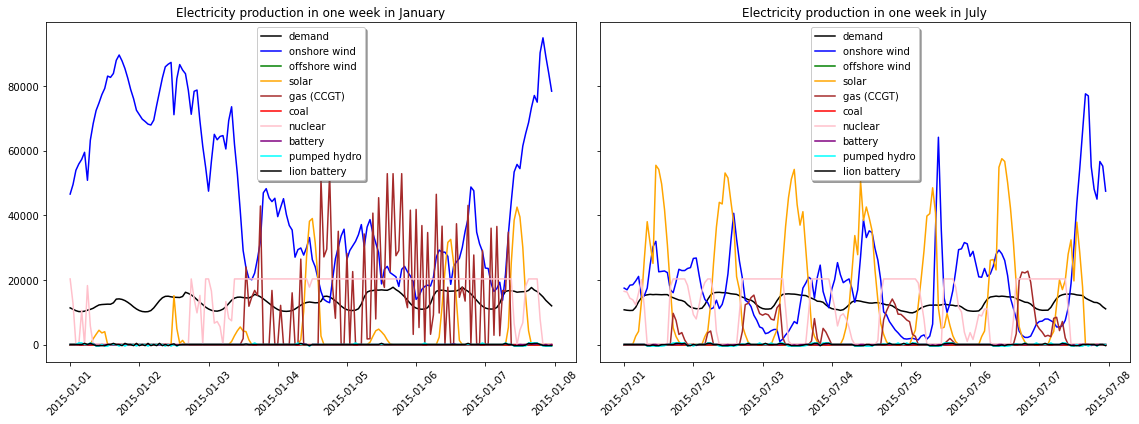

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # 1 row, 2 columns

# --- Winter Week (January) ---
axes[0].plot(network.loads_t.p['load'][0:168], color='black', label='demand')
axes[0].plot(network.generators_t.p['onshorewind'][0:168], color='blue', label='onshore wind')
axes[0].plot(network.generators_t.p['offshorewind'][0:168], color='green', label='offshore wind')
axes[0].plot(network.generators_t.p['solar'][0:168], color='orange', label='solar')
axes[0].plot(network.generators_t.p['CCGT'][0:168], color='brown', label='gas (CCGT)')
axes[0].plot(network.generators_t.p['coal'][0:168], color='red', label='coal')
axes[0].plot(network.generators_t.p['nuclear'][0:168], color='pink', label='nuclear')
axes[0].plot(network.storage_units_t.p['battery'][0:168], color='purple', label='battery')
axes[0].plot(network.storage_units_t.p['pumped_hydro'][0:168], color='cyan', label='pumped hydro')
axes[0].plot(network.storage_units_t.p['lion_battery'][0:168], color='black', label='lion battery')
axes[0].legend(fancybox=True, shadow=True, loc='best')
axes[0].set_title('Electricity production in one week in January')
axes[0].tick_params(axis='x', rotation=45)

# --- Summer Week (July) ---
axes[1].plot(network.loads_t.p['load'][4344:4512], color='black', label='demand')
axes[1].plot(network.generators_t.p['onshorewind'][4344:4512], color='blue', label='onshore wind')
axes[1].plot(network.generators_t.p['offshorewind'][4344:4512], color='green', label='offshore wind')
axes[1].plot(network.generators_t.p['solar'][4344:4512], color='orange', label='solar')
axes[1].plot(network.generators_t.p['CCGT'][4344:4512], color='brown', label='gas (CCGT)')
axes[1].plot(network.generators_t.p['coal'][4344:4512], color='red', label='coal')
axes[1].plot(network.generators_t.p['nuclear'][4344:4512], color='pink', label='nuclear')
axes[1].plot(network.storage_units_t.p['battery'][4344:4512], color='purple', label='battery')
axes[1].plot(network.storage_units_t.p['pumped_hydro'][4344:4512], color='cyan', label='pumped hydro')
axes[1].plot(network.storage_units_t.p['lion_battery'][4344:4512], color='black', label='lion battery')
axes[1].legend(fancybox=True, shadow=True, loc='best')
axes[1].set_title('Electricity production in one week in July')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()